# What types of errors are associated with longer duration reports according to the EFFECTIVE_PAGE_TIME

>Questions being answered in this notebook.
>- [x] What errors are raised through EFFECTIVE_PAGE_TIME?



[THIS ANALYSIS IS NOT COMPLETED]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Loading active reports.

In [2]:
active_reports = pd.read_csv("datasets/active_reports.csv")

C:\Users\jefer\AppData\Local\Temp\ipykernel_9448\2173927402.py:1: DtypeWarning: Columns (10,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  active_reports = pd.read_csv("datasets/active_reports.csv")


In [3]:
active_reports.shape

(38326, 51)

In [4]:
#Reading data
page_view = pd.read_csv("datasets/pageview_logs.csv")

In [5]:
#Page View examples
# page_view.head(3)

In [6]:
page_view.shape

(542852, 18)

In [7]:
active_reports.REPORT_ID_DERIVED.unique().shape[0] * page_view.shape[0]

186198236

In [8]:
page_view.REPORT_ID_DERIVED.unique().shape

(125944,)

In [9]:
# filtering problematic reports
page_view = page_view[page_view.EFFECTIVE_PAGE_TIME.isna()]

In [10]:
page_view.shape

(239359, 18)

In [11]:
# Problematic reports regarding time
page_view = page_view[page_view.DURATION > 60000].sort_values('DURATION', ascending=False).head(100)

In [12]:
active_problematic_reports_set = set(page_view.REPORT_ID_DERIVED.unique())\
    .intersection(set(active_reports.REPORT_ID_DERIVED.unique()))

In [13]:
len(active_problematic_reports_set)

13

In [14]:
active_problematic_reports =\
    active_reports[active_reports.apply(lambda r: r.REPORT_ID_DERIVED in active_problematic_reports_set, axis=1)]

In [15]:
active_problematic_reports.shape

(21421, 51)

In [16]:
active_problematic_page_logs =\
    page_view[page_view.apply(lambda r: r.REPORT_ID_DERIVED in active_problematic_reports_set, axis=1)]

In [17]:
active_problematic_page_logs.shape

(25, 18)

In [18]:
final_active_problematic_reports = pd.merge(left=active_problematic_reports, right=active_problematic_page_logs, on='REPORT_ID_DERIVED')

In [19]:
final_active_problematic_reports.shape

(86957, 68)

In [20]:
final_active_problematic_reports.REPORT_ID_DERIVED.unique().shape

(13,)

In [21]:
final_active_problematic_reports.drop(columns=['EFFECTIVE_PAGE_TIME'], inplace=True)

In [22]:
final_active_problematic_reports.rename(columns={'Name': 'ReportName', 'DURATION': 'AvgEffectivePageTime'}, inplace=True)

In [23]:
#Filtering just the time spend of the Events
ept_metric = final_active_problematic_reports[['ReportName', 'AvgEffectivePageTime']].groupby('ReportName').agg('mean').reset_index()

In [24]:
ept_metric.sort_values('AvgEffectivePageTime', ascending=False).head(10)

,ReportName,AvgEffectivePageTime
12,Wipro NCC Details - Midrange,905692.000
6,My Team's Cases Without Tasks V1.0,877588.000
7,New Email By Team - w\o Sup filter,843297.625
11,Wipro - SR Assigned but SLO not Met,656406.000
5,My Cases and Tasks,585729.000
3,"Cases with Tasks, Calendar & Reminders",584099.000
10,Tech Support SRs in Routing/Exception,468862.000
4,Chat Average Handle Time,448006.000
0,AMER PDP PowerScale - Config Scheduled,392648.000
2,Agents_Case by Status,358463.000


In [46]:
#Filtering just the time spend of the Events
runtime_metric = final_active_problematic_reports[['ReportName', 'RUN_TIME']]\
    .groupby('ReportName')\
    .agg('mean')\
    .rename(columns={'RUN_TIME': 'AvgRuntime'})\
    .sort_values('AvgRuntime', ascending=False)\
    .reset_index()

In [47]:
runtime_metric.AvgRuntime = runtime_metric.AvgRuntime / 1000 # to secs
runtime_metric.head(10)
# The amount of time that the request took in milliseconds.

,ReportName,AvgRuntime
0,AMER PDP PowerScale - Config Scheduled,170.577789
1,Open Tasks (Blue Steel),52.698925
2,Wipro - SR Assigned but SLO not Met,34.419071
3,Agent Level Report,19.961650
4,Tech Support SRs in Routing/Exception,13.565500
5,Wipro NCC Details - Midrange,12.544194
6,"Cases with Tasks, Calendar & Reminders",8.798093
7,S&AS Reactive Queues,8.065553
8,New Email By Team - w\o Sup filter,3.787716
9,Chat Average Handle Time,3.705288


In [48]:
final_active_problematic_reports.DB_TOTAL_TIME = final_active_problematic_reports.DB_TOTAL_TIME / 10e6 # ns -> ms

In [49]:
final_active_problematic_reports['DB_TIME'] = final_active_problematic_reports.DB_TOTAL_TIME - final_active_problematic_reports.DB_CPU_TIME 

In [51]:
db_time_metric = final_active_problematic_reports[['ReportName', 'DB_TIME']]\
    .groupby('ReportName')\
    .agg('mean')\
    .rename(columns={'DB_TIME': 'AvgDatabaseTime'})\
    .sort_values('AvgDatabaseTime', ascending=False)\
    .reset_index()

In [54]:
db_time_metric.head()

,ReportName,AvgDatabaseTime
0,AMER PDP PowerScale - Config Scheduled,22507.242509
1,Agent Level Report,3656.206512
2,Tech Support SRs in Routing/Exception,556.751956
3,Wipro NCC Details - Midrange,235.161009
4,Wipro - SR Assigned but SLO not Met,164.653807


In [55]:
db_cpu_time_metric = final_active_problematic_reports[['ReportName', 'DB_CPU_TIME']]\
    .groupby('ReportName')\
    .agg('mean')\
    .rename(columns={'DB_CPU_TIME': 'AVG_DB_CPU_TIME'})\
    .sort_values('AVG_DB_CPU_TIME', ascending=False)\
    .reset_index()

In [57]:
db_cpu_time_metric.head()

,ReportName,AVG_DB_CPU_TIME
0,Open Tasks (Blue Steel),21310.294118
1,"Cases with Tasks, Calendar & Reminders",3778.917073
2,S&AS Reactive Queues,1598.568988
3,Wipro NCC Details - Midrange,1384.316547
4,Tech Support SRs in Routing/Exception,850.824742


In [58]:
db_cpu_time_metric.rename(columns={'AVG_DB_CPU_TIME': 'AvgApplicationTime'}).head()

,ReportName,AvgApplicationTime
0,Open Tasks (Blue Steel),21310.294118
1,"Cases with Tasks, Calendar & Reminders",3778.917073
2,S&AS Reactive Queues,1598.568988
3,Wipro NCC Details - Midrange,1384.316547
4,Tech Support SRs in Routing/Exception,850.824742


In [66]:
ctx_metric = final_active_problematic_reports[['ReportName', 'PAGE_APP_NAME']]\
    .groupby('ReportName')\
    .agg({'PAGE_APP_NAME': 'unique'})
#     .sort_values('AVG_DB_CPU_TIME', ascending=False)\
#     .reset_index()

In [67]:
ctx_metric

,PAGE_APP_NAME
ReportName,
AMER PDP PowerScale - Config Scheduled,[PSA_Dell]
Agent Level Report,[LightningService]
Agents_Case by Status,[LightningService]
"Cases with Tasks, Calendar & Reminders",[LightningService]
Chat Average Handle Time,[LightningService]
My Cases and Tasks,[LightningService]
My Team's Cases Without Tasks V1.0,[LightningService]
New Email By Team - w\o Sup filter,[LightningService]
Open Tasks (Blue Steel),[LightningService]


In [68]:
final_active_problematic_reports.APP_NAME.unique()

array(['one:one'], dtype=object)

In [76]:
final_active_problematic_reports.PAGE_APP_NAME.value_counts()

Series([], Name: ENTITY_NAME, dtype: int64)

In [80]:
final_active_problematic_reports.RENDERING_TYPE.unique()

array([nan])

In [84]:
cpu_time_metric = final_active_problematic_reports[['ReportName', 'RUN_TIME']]\
    .groupby('ReportName')\
    .agg('mean')\
    .rename(columns={'RUN_TIME': 'AVERAGE_RUN_TIME'})\
    .sort_values('AVERAGE_RUN_TIME', ascending=False)\
    .reset_index()

In [85]:
cpu_time_metric.head()

,ReportName,AVERAGE_RUN_TIME
0,AMER PDP PowerScale - Config Scheduled,170577.789474
1,Open Tasks (Blue Steel),52698.924855
2,Wipro - SR Assigned but SLO not Met,34419.071429
3,Agent Level Report,19961.650000
4,Tech Support SRs in Routing/Exception,13565.500000


#### According to the documentation, the EFFECTIVE_PAGE_TIME (alternative to DURATION that is current deprecated) will be 0/null if there's an error in any moment of the Page execution. Even though deprecated, due that behavior, the column DURATION showed to be more accurated to tell the true rum time of the page, regardless any errors.

## Mean Runtime of a successful Page

In [ ]:
m = page_view_time.EFFECTIVE_PAGE_TIME.mean()/1000
print(f'The mean run-time of a successful Page rendered is {m}')

## Percentage of Erros in the Pages

In [ ]:
page_view_error_log = page_view_indexed[page_view_indexed.EFFECTIVE_PAGE_TIME_DEVIATION == True][['EFFECTIVE_PAGE_TIME_DEVIATION_REASON']]
page_view_error_log

In [26]:
#Percentage of each Error Type
final_active_problematic_reports.EFFECTIVE_PAGE_TIME_DEVIATION_REASON.value_counts()

PreviousPageNotLoaded                36705
PageNotLoaded                        27533
PageHasError                         21807
InteractionBeforePageLoaded|click      912
Name: EFFECTIVE_PAGE_TIME_DEVIATION_REASON, dtype: int64

## Type of Errors:
#### PAGE_IN_DOM
    The page was loaded from a cache.
#### PAGE_NOT_LOADED
    If a customer navigates away from a page while loading processes are in progress, the page doesn't finish loading.
#### PREVIOUS_PAGE_NOT_LOADED
    When navigating to a new page, and the previous page hasn't completed loading, the next page is considered to have a deviation. Incomplete loading processes on a previous page can affect how the next page loads.
#### INTERACTIONS_BEFORE_PAGE_LOADED
    A user interacts with a page element before the page is fully loaded.
#### PAGE_IN_BACKGROUND_BEFORE_LOADED
    A background loading process runs on a page. Background processes can run when users don't interact with a page, such as when they navigate to another browser tab.

#  Error Types pie chart

In [89]:
final_active_problematic_reports.REPORT_ID_DERIVED.unique().shape

(13,)

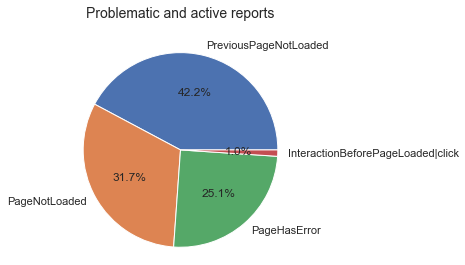

In [37]:
sizes = list(final_active_problematic_reports.EFFECTIVE_PAGE_TIME_DEVIATION_REASON.value_counts())
labels = list(final_active_problematic_reports.EFFECTIVE_PAGE_TIME_DEVIATION_REASON.value_counts().index)

fig, ax = plt.subplots()
ax.set_title('Problematic and active reports\n', fontsize=14)
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')
plt.show()

In [ ]:
page_view_indexed.to_csv('Page_View_by_USER_ID_DERIVED-SESSI')